**4) Perform a predictive modeling analysis on this same dataset (Problem 5 of HW1) using the decision tree, k-NN techniques, logistic regression and SVM (explore how well model performs for several different hyper-parameter values). Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make sure your present information about the model “goodness” (possible things to think about: confusion matrix, predictive accuracy, precision, recall, f-measure). Briefly discuss ROC and lift curves.**

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.datasets import make_classification
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

In [2]:
# Load the dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

In [3]:
# load_breast_cancer() returns a dictionary-like object. The interesting attributes are: 
# ‘data’, the data to learn, 
# ‘target’, the classification labels, 
# ‘target_names’, the meaning of the labels, 
# ‘feature_names’, the meaning of the features, and 
# ‘DESCR’, the full description of the dataset.

# details for this data set: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
## Explore the data set
n_samples, n_features = cancer.data.shape
#print(breast_cancer.keys())
print ('The dimensions of the data set are', n_samples, 'by', n_features)
# It is made of 569 observations , each described by 30 features: radius, texture, perimenter, area, as detailed in breast_cancer.DESCR.

#print(breast_cancer.data.shape)
#print(breast_cancer.target.shape)
print('The classes are: ', cancer.target_names)
print('The features in the data set are:', cancer.feature_names)

# This data sets consists of 2 different types of cancer (malignant and benign) radius, texture, perimenter, area, stored
# in a 569x30 numpy.ndarray
# The rows being the samples and the columns being: the 30 fields described.

The dimensions of the data set are 569 by 30
The classes are:  ['malignant' 'benign']
The features in the data set are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


There are 0 missing values

Count of Malignant tumors 212
Count of Benign tumors 357


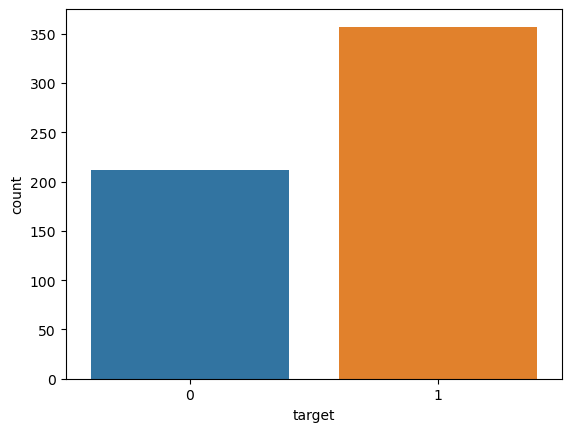

In [5]:
## Visualization of the data set
from mpl_toolkits.mplot3d import Axes3D

#X = breast_cancer.data
#y = breast_cancer.target

X,y = load_breast_cancer(return_X_y=True, as_frame=True)
print(f'There are {pd.concat([X,y], axis=1).isnull().sum().sum()} missing values')
print()
print(f'Count of Malignant tumors {y.value_counts()[0]}')
print(f'Count of Benign tumors {y.value_counts()[1]}')

ax = sns.countplot(x=y, label='Count')
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.15,random_state=45)

In [19]:
# Number of random trials
NUM_TRIALS = 10

# Set up possible values of parameters to optimize over
dt_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a pipeline with Standard Scaler and Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the data
    ('classifier', LogisticRegression(max_iter=1000, solver='saga'))  # Step 2: Apply Logistic Regression
])


lr_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [1000],  # Added max_iter to the grid
    'classifier__solver': ['newton-cg', 'saga']  # Added solver to the grid
}

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
knn_metric = ["euclidean", "manhattan"]

knn_grid = dict(n_neighbors = k_range, weights = weight_options, metric = knn_metric)

# Hyperparameter grid for SVM
svm_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__degree': [2, 3, 4, 5],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__coef0': [0, 1, 2, 3]
}

# Create a pipeline with Standard Scaler and SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])


# Defining the classifier to be used
dt = tree.DecisionTreeClassifier()
knn = KNeighborsClassifier()

# Arrays to store scores
dt_scores = np.zeros(NUM_TRIALS)
lr_scores = np.zeros(NUM_TRIALS)
knn_scores = np.zeros(NUM_TRIALS)
svm_scores = np.zeros(NUM_TRIALS)

best_params = {}

In [20]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Loop for each trial
#Chose cross validation techniques for the inner and outer loops, independantly of the dataset
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    scoring = 'accuracy'
    # Non_nested parameter search and scoring
    dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)
    lr_clf = GridSearchCV(estimator=pipeline_lr, param_grid=lr_grid, scoring = scoring, cv=inner_cv)
    knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)
    svm_clf = GridSearchCV(estimator=pipeline_svm, param_grid=svm_grid, scoring = scoring, cv=inner_cv)
    
    # Nested CV with parameter optimization
    dt_score = cross_val_score(dt_clf, X=X_train, y=y_train, cv=outer_cv)
    dt_scores[i] = dt_score.mean()
    lr_score = cross_val_score(lr_clf, X=X_train, y=y_train, cv=outer_cv)
    lr_scores[i] = lr_score.mean()
    knn_score = cross_val_score(knn_clf, X=X_train, y=y_train, cv=outer_cv)
    knn_scores[i] = knn_score.mean()
    svm_score = cross_val_score(svm_clf, X=X_train, y=y_train, cv=outer_cv)
    svm_scores[i] = svm_score.mean()
    
    print(f"Trial {i+1}")
    print(f"Decision Tree Accuracy: {dt_scores[i]}")
    print(f"Logistic Regression Accuracy: {lr_scores[i]}")
    print(f"k-NN Accuracy: {knn_scores[i]}")
    print(f"SVM Accuracy: {svm_scores[i]}")
    print("-------------------------------")

# Calculate mean scores across all trials
mean_dt_score = np.mean(dt_scores)
mean_lr_score = np.mean(lr_scores)
mean_knn_score = np.mean(knn_scores)
mean_svm_score = np.mean(svm_scores)

# Find the best model based on mean score
best_model_score = np.max([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score])
model_names = ["Decision Tree", "Logistic Regression", "k-NN", "SVM"]
best_model_index = np.argmax([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score])
best_model_name = model_names[best_model_index]

# Extract best parameters for the best model
if best_model_name == "Decision Tree":
    dt_clf.fit(X_train, y_train)
    best_params = dt_clf.best_params_
elif best_model_name == "Logistic Regression":
    lr_clf.fit(X_train, y_train)
    best_params = lr_clf.best_params_
elif best_model_name == "k-NN":
    knn_clf.fit(X_train, y_train)
    best_params = knn_clf.best_params_
elif best_model_name == "SVM":
    svm_clf.fit(X_train, y_train)
    best_params = svm_clf.best_params_

print(f"Best Model: {best_model_name} with mean score {best_model_score}")
print(f"Best Parameters: {best_params}")

Trial 1
Decision Tree Accuracy: 0.9275654269972451
Logistic Regression Accuracy: 0.9730888429752066
k-NN Accuracy: 0.9254476584022038
SVM Accuracy: 0.975137741046832
-------------------------------
Trial 2
Decision Tree Accuracy: 0.9378615702479338
Logistic Regression Accuracy: 0.9689221763085399
k-NN Accuracy: 0.9378960055096419
SVM Accuracy: 0.9772555096418732
-------------------------------
Trial 3
Decision Tree Accuracy: 0.9233298898071626
Logistic Regression Accuracy: 0.9648071625344353
k-NN Accuracy: 0.9399793388429751
SVM Accuracy: 0.968939393939394
-------------------------------
Trial 4
Decision Tree Accuracy: 0.9316287878787879
Logistic Regression Accuracy: 0.9730888429752066
k-NN Accuracy: 0.9378960055096419
SVM Accuracy: 0.9792871900826446
-------------------------------
Trial 5
Decision Tree Accuracy: 0.9214015151515151
Logistic Regression Accuracy: 0.9751721763085399
k-NN Accuracy: 0.9441460055096419
SVM Accuracy: 0.9855199724517907
-------------------------------
Trial 6

In [29]:
# Arrays to store scores
dt_scores = np.zeros(NUM_TRIALS)
lr_scores = np.zeros(NUM_TRIALS)
knn_scores = np.zeros(NUM_TRIALS)
svm_scores = np.zeros(NUM_TRIALS)

best_params = {}

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Loop for each trial
#Chose cross validation techniques for the inner and outer loops, independantly of the dataset
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    scoring = make_scorer(recall_score, pos_label=0) #as the '0' class is malignant
    # Non_nested parameter search and scoring
    dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring = scoring, cv=inner_cv)
    lr_clf = GridSearchCV(estimator=pipeline_lr, param_grid=lr_grid, scoring = scoring, cv=inner_cv)
    knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = scoring, cv=inner_cv)
    svm_clf = GridSearchCV(estimator=pipeline_svm, param_grid=svm_grid, scoring = scoring, cv=inner_cv)
    
    # Nested CV with parameter optimization
    dt_score = cross_val_score(dt_clf, X=X_train, y=y_train, cv=outer_cv)
    dt_scores[i] = dt_score.mean()
    lr_score = cross_val_score(lr_clf, X=X_train, y=y_train, cv=outer_cv)
    lr_scores[i] = lr_score.mean()
    knn_score = cross_val_score(knn_clf, X=X_train, y=y_train, cv=outer_cv)
    knn_scores[i] = knn_score.mean()
    svm_score = cross_val_score(svm_clf, X=X_train, y=y_train, cv=outer_cv)
    svm_scores[i] = svm_score.mean()
    
    print(f"Trial {i+1}")
    print(f"Decision Tree recall: {dt_scores[i]}")
    print(f"Logistic Regression recall: {lr_scores[i]}")
    print(f"k-NN recall: {knn_scores[i]}")
    print(f"SVM recall: {svm_scores[i]}")
    print("-------------------------------")

# Calculate mean scores across all trials
mean_dt_score = np.mean(dt_scores)
mean_lr_score = np.mean(lr_scores)
mean_knn_score = np.mean(knn_scores)
mean_svm_score = np.mean(svm_scores)

# Find the best model based on mean score
best_model_score = np.max([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score])
model_names = ["Decision Tree", "Logistic Regression", "k-NN", "SVM"]
best_model_index = np.argmax([mean_dt_score, mean_lr_score, mean_knn_score, mean_svm_score])
best_model_name = model_names[best_model_index]

# Extract best parameters for the best model
if best_model_name == "Decision Tree":
    dt_clf.fit(X_train, y_train)
    best_params = dt_clf.best_params_
elif best_model_name == "Logistic Regression":
    lr_clf.fit(X_train, y_train)
    best_params = lr_clf.best_params_
elif best_model_name == "k-NN":
    knn_clf.fit(X_train, y_train)
    best_params = knn_clf.best_params_
elif best_model_name == "SVM":
    svm_clf.fit(X_train, y_train)
    best_params = svm_clf.best_params_

print(f"Best Model: {best_model_name} with mean score {best_model_score}")
print(f"Best Parameters: {best_params}")

Trial 1
Decision Tree recall: 0.9355541075465887
Logistic Regression recall: 0.9676343393448656
k-NN recall: 0.9119067023202362
SVM recall: 0.9580189547294811
-------------------------------
Trial 2
Decision Tree recall: 0.8957509881422925
Logistic Regression recall: 0.9616937179379363
k-NN recall: 0.9070988562778572
SVM recall: 0.9510711882936675
-------------------------------
Trial 3
Decision Tree recall: 0.8255679091345385
Logistic Regression recall: 0.9460457755330576
k-NN recall: 0.9175817583472359
SVM recall: 0.9577267637178052
-------------------------------
Trial 4
Decision Tree recall: 0.8851965669988925
Logistic Regression recall: 0.9484717607973422
k-NN recall: 0.9130537098560354
SVM recall: 0.9287991417497231
-------------------------------
Trial 5
Decision Tree recall: 0.9341853798375537
Logistic Regression recall: 0.9440567196778378
k-NN recall: 0.9131117329875094
SVM recall: 0.9409056264646327
-------------------------------
Trial 6
Decision Tree recall: 0.8822126242095

In the context of breast cancer detection, the primary objective is to identify as many true positive cases as possible. In medical terms, a "true positive" is a case where the model correctly identifies that cancer is present. Missing a positive case (false negative) could have severe consequences, including delayed treatment, which could be life-threatening. On the other hand, a false positive, while still an issue, is generally less problematic because further medical tests can be conducted for confirmation.

Why Recall is Important:
**Minimizing False Negatives:** Recall focuses on minimizing false negatives. A high recall means fewer cases of cancer go undetected.

**Life-critical Application:** In life-critical applications like cancer detection, the cost of missing a positive case is very high, making recall a more important metric.

Recall= True Positives/True Positives+False Negatives

Why Accuracy May Not Be the Best Metric:
**Different Costs for Errors:** Accuracy treats all types of errors equally, whereas in medical diagnosis, false negatives and false positives have very different costs.

**Doesn't Reflect Objective:** The primary objective is to identify all positive cases, which is directly measured by recall, not accuracy.

From a business analytics standpoint, understanding the cost and impact of different types of errors is crucial for model evaluation. In healthcare, the cost of a false negative could be a human life, making it far more costly than a false positive, which might "only" lead to additional tests or temporary emotional stress. Therefore, a model with higher recall could be considered more valuable in this context.

**Logistic regression is the best model to go ahead as it's recall is good compared to the rest and the accuracy is also in the range of above 0.9**

Confusion Matrix:
[[27  2]
 [ 0 57]]

Predictive Accuracy: 97.67%

Classification Error: 2.33%

Recall for Class 0: 93.10%

Classification Report (Precision, Recall, F-measure):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        29
           1       0.97      1.00      0.98        57

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



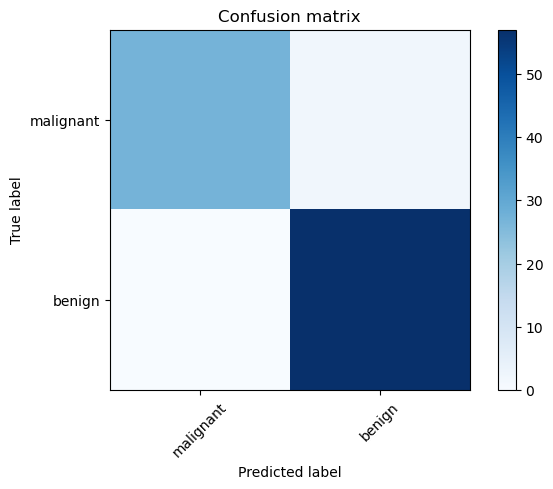

In [30]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cancer.target_names))
    plt.xticks(tick_marks, cancer.target_names, rotation=45)
    plt.yticks(tick_marks, cancer.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict labels for test data
best_lr_clf = lr_clf.best_estimator_
y_pred = best_lr_clf.predict(X_test)


# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure()
plot_confusion_matrix(conf_matrix)

# Calculate and display the predictive accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPredictive Accuracy: {accuracy*100:.2f}%")

# Calculate and display classification error
classification_error = 1 - accuracy
print(f"\nClassification Error: {classification_error*100:.2f}%")

# Calculate and display recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
print(f"\nRecall for Class 0: {recall_0*100:.2f}%")

# Calculate and display precision, recall, and f-measure
print("\nClassification Report (Precision, Recall, F-measure):")
print(classification_report(y_test, y_pred))

The model has **accuracy of 97.67%** and **recall for '0' class** i.e.. malignant class as **93.1%**

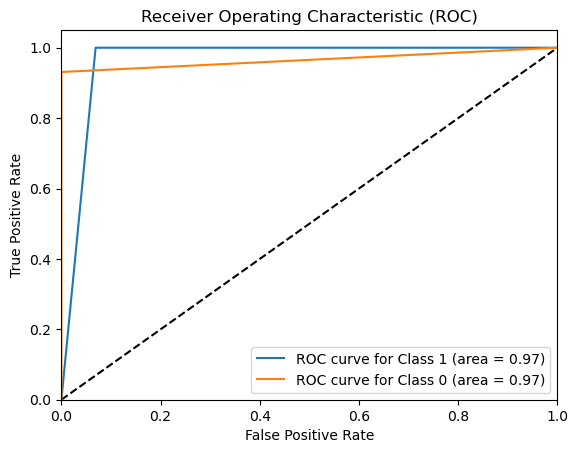

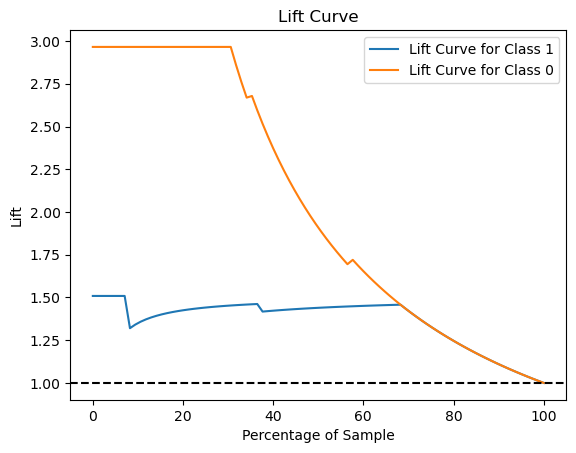

In [41]:
   # Plot ROC curve for Class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve for Class 1 (area = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Plot ROC curve for Class 0
y_test_inv = 1 - y_test
y_pred_inv = 1 - y_pred
fpr_class0, tpr_class0, thresholds_class0 = roc_curve(y_test_inv, y_pred_inv)
plt.plot(fpr_class0, tpr_class0, label=f'ROC curve for Class 0 (area = {roc_auc_score(y_test_inv, y_pred_inv):.2f})')
plt.legend(loc="lower right")
plt.show()

# Calculate metrics for Lift curve for Class 1
actual_positives = sum(y_test)
total_cases = len(y_test)
baseline_lift = actual_positives / total_cases
sorted_indices = np.argsort(y_pred)[::-1]
sorted_actual = y_test[sorted_indices]
lift_scores = []
for i in range(1, len(sorted_actual) + 1):
    lift = sum(sorted_actual[:i]) / i
    lift_scores.append(lift / baseline_lift)

# Calculate metrics for Lift curve for Class 0
y_test_inv = 1 - y_test
y_pred_inv = 1 - y_pred
actual_positives_class0 = sum(y_test_inv)
baseline_lift_class0 = actual_positives_class0 / total_cases
sorted_indices_class0 = np.argsort(y_pred_inv)[::-1]
sorted_actual_class0 = y_test_inv[sorted_indices_class0]
lift_scores_class0 = []
for i in range(1, len(sorted_actual_class0) + 1):
    lift_class0 = sum(sorted_actual_class0[:i]) / i
    lift_scores_class0.append(lift_class0 / baseline_lift_class0)

# Create the plot
plt.figure()

# Plot Lift curve for Class 1 with x-axis as percentage of sample
plt.plot(np.linspace(0, 100, len(lift_scores)), lift_scores, label='Lift Curve for Class 1')

# Plot Lift curve for Class 0 with x-axis as percentage of sample
plt.plot(np.linspace(0, 100, len(lift_scores_class0)), lift_scores_class0, label='Lift Curve for Class 0')

# Add baseline at y=1
plt.axhline(y=1, color='k', linestyle='--')

# Label the axes and add title and legend
plt.xlabel('Percentage of Sample')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="upper right")

# Show the plot
plt.show()

We can see a healthy **ROC curve**, pushed towards the top-left side both for positive and negative classes. 
In order to get one number that tells us how good our curve is, we can calculate the Area Under the ROC Curve, or ROC AUC score. The more top-left your curve is the higher the area and hence higher ROC AUC score.

Alternatively, it can be shown that ROC AUC score is equivalent to calculating the rank correlation between predictions and targets. From an interpretation standpoint, it is more useful because it tells us that this metric shows how good at ranking predictions your model is. It tells you what is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance.**The AUC is 0.97, indicating good separability**

The lift chart provides an easy way to visualize how many times better applying the model is than random selection for any percentage of the ranked records. The Lift Curve shows how much more effective the model is compared to random guessing. For example, if the **lift is 3.0 when considering the top 35% of the ranked records**, it means that targeting this top 35% based on the model's predictions is 3 times more effective than random selection

As you move further along the x-axis (i.e., consider more and more records), the lift generally decreases. This is because the model's ability to discriminate between the classes diminishes as you include more instances that are less confidently classified.A classifier that works really well will produce a high “lift” for the selection of a relatively small percentage of the ranked data.A high lift value at the beginning of the curve indicates that the model is very good at ranking the most likely positive instances at the top. This is often the most crucial part of the curve in applications like marketing, where resources for targeting are limited

In [42]:
## details of the best model

best_model = best_lr_clf.named_steps['classifier']
coefficients = best_model.coef_

# Check if X is a DataFrame and get column names
if isinstance(X, pd.DataFrame):
    feature_names = X.columns
else:
    feature_names = [str(i) for i in range(X.shape[1])]

# For better interpretation, map these coefficients back to the respective feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients.flatten()})

# Sort and display
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
11            texture error    1.714778
19  fractal dimension error    1.501651
15        compactness error    1.002869
25        worst compactness    0.579005
9    mean fractal dimension    0.432699
5          mean compactness    0.420230
1              mean texture    0.263819
18           symmetry error    0.134853
0               mean radius    0.000551
2            mean perimeter    0.000042
8             mean symmetry    0.000000
12          perimeter error    0.000000
4           mean smoothness    0.000000
17     concave points error    0.000000
16          concavity error   -0.111694
3                 mean area   -0.165950
29  worst fractal dimension   -0.608031
14         smoothness error   -0.928813
24         worst smoothness   -0.978283
26          worst concavity   -1.022741
28           worst symmetry   -1.273165
27     worst concave points   -1.412983
10             radius error   -1.575172
7       mean concave points   -1.761488
